# Title: Electron Microscopy Image Segmentation using U-Net

Goal:

The primary goal of this project is to develop a machine learning model that can effectively segment specific structures within electron microscopy images. Segmentation involves identifying and delineating regions of interest (ROI) within the images, such as cellular components or other biological structures.

In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

## Data

[Dataset](https://www.kaggle.com/datasets/dat0chin/electron-microscopy-dataset)

The project utilizes a dataset of electron microscopy images paired with corresponding masks. These masks are essentially annotations that outline the structures of interest within each image. The data is split into two sets:

* Training Set: Used to train the machine learning model, helping it learn to predict the segmentation masks from the images.
* Testing Set: Used to evaluate the model's performance, ensuring that it generalizes well to new, unseen data.

In [ ]:
image_directory = '../input/electron-microscopy-dataset/train/data/'
mask_directory = '../input/electron-microscopy-dataset/train/label/'


SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

## Preprocessing:
* Images and masks are loaded, resized to a uniform dimension (256x256 pixels), and appropriately normalized or rescaled. This standardization is crucial for effective model training.
* The preprocessing steps also ensure that the data is in the correct format for processing by the neural network (e.g., adjusting dimensions for grayscale channel).

In [ ]:
images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):

        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))


In [ ]:
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

In [ ]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [ ]:
print(image_dataset.shape)
print(mask_dataset.shape)

(165, 256, 256, 1)
(165, 256, 256, 1)


In [ ]:
image_directory = '../input/electron-microscopy-dataset/test/data/'
mask_directory = '../input/electron-microscopy-dataset/test/label/'


SIZE = 256
image_dataset_test = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
mask_dataset_test = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

In [ ]:
images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):

        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset_test.append(np.array(image))


In [ ]:
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset_test.append(np.array(image))

In [ ]:
#Normalize images
image_dataset_test = np.expand_dims(normalize(np.array(image_dataset_test), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset_test = np.expand_dims((np.array(mask_dataset_test)),3) /255.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

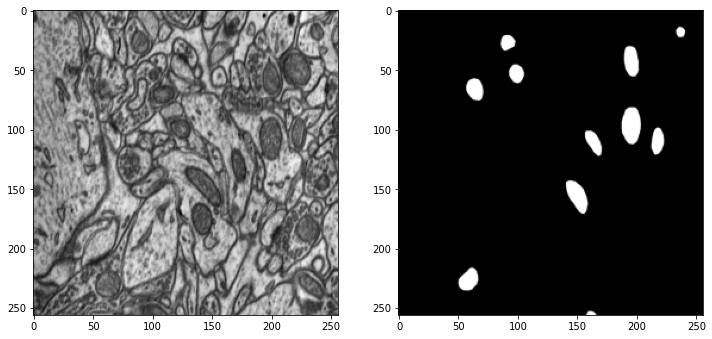

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [ ]:
IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS

(256, 256, 1)

## Model Architecture:
* A U-Net architecture is employed for the segmentation task. U-Net is specifically designed for medical image segmentation due to its ability to work well with fewer training samples and its efficiency in learning from spatial hierarchies of images.
* The architecture includes downsampling (encoder) and upsampling (decoder) paths which help in capturing context and precisely localizing ROI in images.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
model = simple_unet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

2022-02-11 14:52:30.199388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 14:52:30.300195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 14:52:30.300908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 14:52:30.302037: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    shuffle=False)



2022-02-11 14:52:44.332284: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-02-11 14:52:46.845010: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


10/10 [==============================] - 11s 200ms/step - loss: 0.3637 - accuracy: 0.9064 - val_loss: 0.3412 - val_accuracy: 0.9330
Epoch 2/100
10/10 [==============================] - 1s 72ms/step - loss: 0.2403 - accuracy: 0.9344 - val_loss: 0.2709 - val_accuracy: 0.9330
Epoch 3/100
10/10 [==============================] - 1s 71ms/step - loss: 0.2225 - accuracy: 0.9344 - val_loss: 0.2438 - val_accuracy: 0.9330
Epoch 4/100
10/10 [==============================] - 1s 72ms/step - loss: 0.2133 - accuracy: 0.9344 - val_loss: 0.2220 - val_accuracy: 0.9330
Epoch 5/100
10/10 [==============================] - 1s 71ms/step - loss: 0.2082 - accuracy: 0.9344 - val_loss: 0.2266 - val_accuracy: 0.9330
Epoch 6/100
10/10 [==============================] - 1s 75ms/step - loss: 0.2055 - accuracy: 0.9344 - val_loss: 0.2215 - val_accuracy: 0.9330
Epoch 7/100
10/10 [==============================] - 1s 72ms/step - loss: 0.2025 - accuracy: 0.9344 - val_loss: 0.2274 - val_accuracy: 0.9330
Epoch 8/100
10/1

## Evaluation:
The trained model is evaluated using the separate test dataset to assess its performance. Metrics such as accuracy, IoU (Intersection over Union), and Dice coefficient are commonly used to quantify the model’s effectiveness in segmenting images.

In [ ]:
loss, acc = model.evaluate(image_dataset_test, mask_dataset_test)
print("loss = ",loss)
print("Accuracy = ", (acc * 100.0), "%")



6/6 [==============================] - 1s 83ms/step - loss: 0.5320 - accuracy: 0.9305
loss =  0.5320006012916565
Accuracy =  93.04808378219604 %


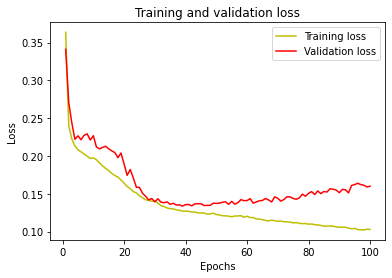

In [ ]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


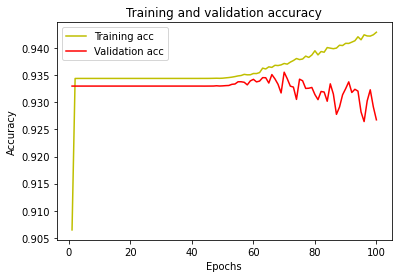

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
##################################
#IOU
y_pred=model.predict(image_dataset_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(mask_dataset_test, y_pred_thresholded)
union = np.logical_or(mask_dataset_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.013288099493359904


In [ ]:
test_img_number = random.randint(0, len(image_dataset_test))
test_img = image_dataset_test[test_img_number]
ground_truth=mask_dataset_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)


In [ ]:
test_img_other = cv2.imread('../input/electron-microscopy-dataset/train/data/train0.tif', 0)
test_img_other=cv2.resize(test_img_other,(IMG_HEIGHT,IMG_WIDTH))
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)

test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, axis=0)

In [ ]:
test_img_other_input.shape

(1, 256, 256, 1)

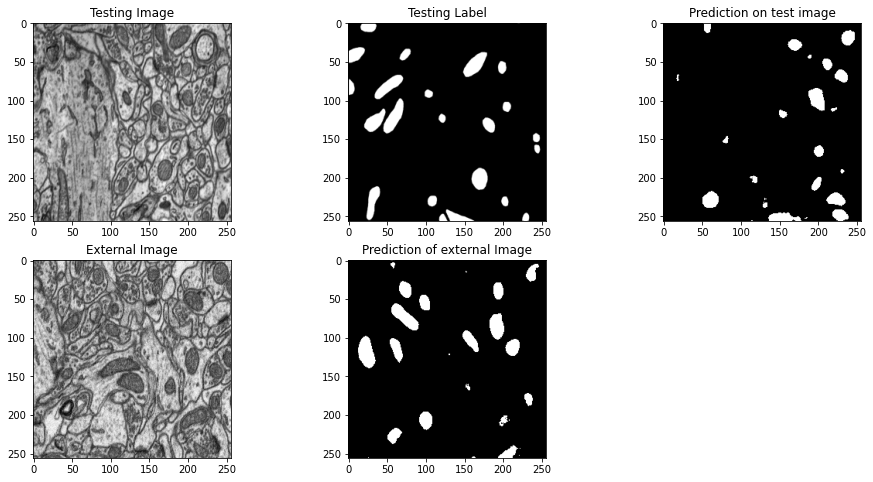

In [ ]:
#Predict and threshold for values above 0.5 probability
#Change the probability threshold to low value (e.g. 0.05) for watershed demo.
prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()

#plt.imsave('input.jpg', test_img[:,:,0], cmap='gray')
#plt.imsave('data/results/output2.jpg', prediction_other, cmap='gray')


* model capable of accurately segmenting new electron microscopy images.
* An effectively trained segmentation model can significantly aid in biological and medical research, where automated and accurate segmentation of microscopy images can expedite analysis and lead to faster discoveries.
*  The project may also explore the scalability of the model to handle larger datasets or its adaptability to other types of biomedical imaging data.

This project aims not only to develop a technical solution but also to contribute to the broader field of computational biology by enhancing the tools available for image-based analyses